### Notebook to genereate plots of binned 2D variables.

James Ruppert  
jruppert@ou.edu  
2/22/24

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import theta_virtual, relh, theta_equiv
# from mask_tc_track import mask_tc_track
from precip_class import precip_class
from memory_usage import memory_usage
from read_functions import *

#### Main settings

In [2]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Time selection
# hr_tag = str(np.char.zfill(str(nt), 2))

# Tests to read and compare
# tests = ['crfon','ncrf']
# if storm == 'haiyan':
#     tests = ['ctl','ncrf36h']
# elif storm == 'maria':
#     # tests = ['ctl','ncrf36h']
#     tests = ['ctl','ncrf48h']
tests = ['ctl']

# Number of sample time steps
nt=200 # will be chopped down to max available
nt=24#6
time_neglect=12 # time steps from start to neglect

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
nmem = 2
enstag = str(nmem)

In [3]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])
nx1-=80*2
nx2-=80*2

# Get WRF file list
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
wrffiles, lat, lon = get_wrf_filelist(datdir)

#### Main loops and compositing

In [4]:
# Main read loops for all variables

# Arrays to save variables
# ntest=len(tests)
dims2d = (nmem,nt,nx1,nx2)
pclass_all = np.zeros(dims2d)
pw_all = np.zeros(dims2d)
satfrac_all = np.zeros(dims2d)
lwacre_all = np.zeros(dims2d)
rain_all = np.zeros(dims2d)

t0=time_neglect # neglect the first 12 time steps
t1=t0+nt

ktest=0
test_str=tests[ktest]
print('Running test: ',test_str)

# Loop over ensemble members

for imemb in range(nmem):

    print('Running imemb: ',memb_all[imemb])

    datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
    print(datdir)

    # Precip class
    q_int = read_qcloud(datdir,t0,t1,drop=True) # mm
    pclass_all[imemb,:,:,:] = precip_class(q_int)

    # LWACRE
    lwacre_all[imemb,:,:,:] = read_lwacre(datdir,t0,t1,drop=True) # W/m2

    # Rain rate
    varname = 'rainrate'
    rain_all[imemb,:,:,:] = var_read_2d(datdir,varname,t0,t1,drop=True)/24 # mm/d --> mm/hr

    # PW, Sat frac
    # pw = var_read_2d(datdir3d,varname,t0,t1,drop=True) # mm
    pw = read_mse_diag(datdir,'pw',2,t0,t1,drop=True) # mm
    pw_sat = read_mse_diag(datdir,'pw_sat',2,t0,t1,drop=True) # mm
    pw_all[imemb,:,:,:] = pw
    satfrac_all[imemb,:,:,:] = 100*pw/pw_sat

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/


In [5]:
# Bin variable settings

def binvar_settings(ivar_select, pw_all, satfrac_all, rain_all, lwacre_all):

    # PW
    if ivar_select == 'pw':
        ivar_all = pw_all
        fmin=35;fmax=80 # mm
        step=1
        bins=np.arange(fmin,fmax+step,step)
        xlabel='Column Water Vapor [mm]'
        log_x='linear'
    # Column saturation fraction
    elif ivar_select == 'sf':
        ivar_all = satfrac_all
        fmin=30;fmax=102 # %
        step=2
        bins=np.arange(fmin,fmax+step,step)
        xlabel='Saturation Fraction [%]'
        log_x='linear'
    # Rainfall rate
    elif ivar_select == 'rain':
        ivar_all = rain_all
        # bins=10.**(np.arange(1,8,0.3)-4)
        bins=10.**(np.arange(0,8,0.3)-4)
        xlabel='Rainfall Rate [mm/hr]'
        log_x='log'
    # LW-ACRE
    elif ivar_select == 'lwacre':
        ivar_all = lwacre_all
        fmin=-50; fmax=200 # W/m2
        step=5
        bins=np.arange(fmin,fmax+step,step)
        xlabel='LW-ACRE [W/m**2]'
        log_x='linear'
    # Stratiform area fraction
    # elif ivar_select == 'strat_area':
    #     fmin=0;fmax=60 # %
    #     step=1
    #     bins=np.arange(fmin,fmax+step,step)
    #     xlabel='Stratiform area fraction [%]'
    #     log_x='linear'

    # Create axis of bin center-points for plotting
    nbins = np.size(bins)
    bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

    return ivar_all, bins, bin_axis, xlabel, log_x

In [28]:
# Binning function

def run_binning(pclass_all, bins, ivar_all, pw_all, satfrac_all, lwacre_all, rain_all):

    # Loop and composite variables

    nbins = np.size(bins)

    nclass=6

    bin_freq=np.zeros(nbins-1) # Bin counts

    pclass_binned=np.full((nbins-1,nclass), np.nan) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
    pw_binned=np.full((nbins-1), np.nan)
    satfrac_binned=np.full((nbins-1), np.nan)
    lwacre_binned=np.full((nbins-1), np.nan)
    rain_binned=np.full((nbins-1), np.nan)

    pw_class=np.full((nbins-1,nclass), np.nan) # Binned by precip_class: 0-non-raining, 1-deep conv, 2-congest, 3-shallow, 4-strat, 5-anvil
    satfrac_class=np.full((nbins-1,nclass), np.nan) # Binned by precip_class: 0-non-raining, 1-deep conv, 2-congest, 3-shallow, 4-strat, 5-anvil
    lwacre_class=np.full((nbins-1,nclass), np.nan) # Binned by precip_class: 0-non-raining, 1-deep conv, 2-congest, 3-shallow, 4-strat, 5-anvil
    rain_class=np.full((nbins-1,nclass), np.nan) # Binned by precip_class: 0-non-raining, 1-deep conv, 2-congest, 3-shallow, 4-strat, 5-anvil

    nmin = 3

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for ibin in range(nbins-1):

        indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()
        bin_freq[ibin] = indices[0].shape[0]

        if indices[0].shape[0] > nmin:
            pw_binned[ibin]       = np.mean(pw_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            satfrac_binned[ibin]  = np.mean(satfrac_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            lwacre_binned[ibin]   = np.mean(lwacre_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            rain_binned[ibin]     = np.mean(rain_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
        else:
            continue
            # Else will leave bins filled with NaN

        for kclass in range(nclass):
            indices_strat = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1]) & (pclass_all == kclass)).nonzero()

            pclass_binned[ibin,kclass] = indices_strat[0].shape[0]

            # Bin the 2D var by rain class
            if indices_strat[0].shape[0] > nmin:
                pw_class[ibin,kclass] = np.mean(pw_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0)
                satfrac_class[ibin,kclass] = np.mean(satfrac_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0)
                lwacre_class[ibin,kclass] = np.mean(lwacre_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0)
                rain_class[ibin,kclass] = np.mean(rain_all[indices_strat[0],indices_strat[1],indices_strat[2],indices_strat[3]], axis=0)
    
    # Calculate Area Fraction for each class
    pclass_area=np.ma.zeros((nbins-1,nclass))
    total=np.nansum(pclass_binned)
    for kclass in range(nclass):
        pclass_area[:,kclass] = pclass_binned[:,kclass]/total*1e2

    binned_vars = {
        'bin_freq':bin_freq, 'pclass_binned':pclass_binned, 'pclass_area':pclass_area, 'pw_binned':pw_binned, 'satfrac_binned':satfrac_binned,
        'lwacre_binned':lwacre_binned, 'rain_binned':rain_binned, 'pw_class':pw_class, 'satfrac_class':satfrac_class,
        'lwacre_class':lwacre_class, 'rain_class':rain_class}

    return binned_vars

---
### Plotting routines

In [7]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [8]:
def plot_pclass_area(bins, pclass_area, tests, xlabel, log_x):
        test_str=tests[ktest]
        fig_title = 'Precip Class Area Fraction ('+test_str.upper()+')'
        # create figure
        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_xscale(log_x)
        # As fraction of all-points-total
        ax.set_ylabel('Area Fraction [%]')
        nbins = np.size(bins)
        # plt.plot(bins[0:nbins-1], pclass_area[:,0] \
        #         , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], pclass_area[:,1], "-r", label="Deep")
        plt.plot(bins[0:nbins-1], pclass_area[:,2], "--r", label="Cong")
        plt.plot(bins[0:nbins-1], pclass_area[:,3], ":r", label="Shallow")
        plt.plot(bins[0:nbins-1], pclass_area[:,4], "-b", label="Strat")
        plt.plot(bins[0:nbins-1], pclass_area[:,5], "--b", label="Anvil")
        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 0.020)
        plt.legend(loc="upper left")
        # ax2=ax.twinx()
        # ax2.plot(bins[0:nbins-1], acre_binned, "-k", label="ACRE", linewidth=2)
        # ax2.set_ylabel('ACRE [W/m$^2$]')
        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [34]:
def plot_cbinned_acre(bins, lwacre_class, tests, xlabel, log_x):
        test_str=tests[ktest]
        fig_title = 'LW-ACRE Binned by Precip Class ('+test_str.upper()+')'
        # create figure
        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_xscale(log_x)
        ax.set_ylabel('LW-ACRE [W/m$^2$]')
        nbins = np.size(bins)
        # plt.plot(bins[0:nbins-1], pclass_area[:,0] \
        #         , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], lwacre_class[:,1], "-r", label="Deep")
        plt.plot(bins[0:nbins-1], lwacre_class[:,2], "--r", label="Cong")
        plt.plot(bins[0:nbins-1], lwacre_class[:,3], ":r", label="Shallow")
        plt.plot(bins[0:nbins-1], lwacre_class[:,4], "-b", label="Strat")
        plt.plot(bins[0:nbins-1], lwacre_class[:,5], "--b", label="Anvil")
        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 0.020)
        # plt.legend(loc="upper left")
        # ax2=ax.twinx()
        # ax2.plot(bins[0:nbins-1], acre_binned, "-k", label="ACRE", linewidth=2)
        # ax2.set_ylabel('ACRE [W/m$^2$]')
        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [16]:
def plot_rain_acre(bins, rain_binned, acre_binned, tests, xlabel, log_x):
        test_str=tests[ktest]
        fig_title = test_str.upper()
        # create figure
        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_xscale(log_x)
        # As fraction of all-points-total
        ax.set_ylabel('Rain Rate [mm/hr]')
        nbins = np.size(bins)
        # plt.plot(bins[0:nbins-1], pclass_area[:,0] \
        #         , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], rain_binned, "-k")
        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 0.020)
        ax2=ax.twinx()
        ax2.plot(bins[0:nbins-1], acre_binned, "-r")#, linewidth=2)
        ax2.set_ylabel('LW-ACRE [W/m$^2$]')
        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [25]:
def plot_bin_freq(bins, bin_freq, tests, xlabel, log_x):
        test_str=tests[ktest]
        fig_title = test_str.upper()
        # create figure
        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_xscale(log_x)
        # As fraction of all-points-total
        ax.set_ylabel('Bin Frequency [%]')
        nbins = np.size(bins)
        total = np.nansum(bin_freq)
        plt.plot(bins[0:nbins-1], 100*bin_freq/total, "-k")
        plt.xlim(np.min(bins), np.max(bins))
        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

### Run binning and plotting

Running for  sf



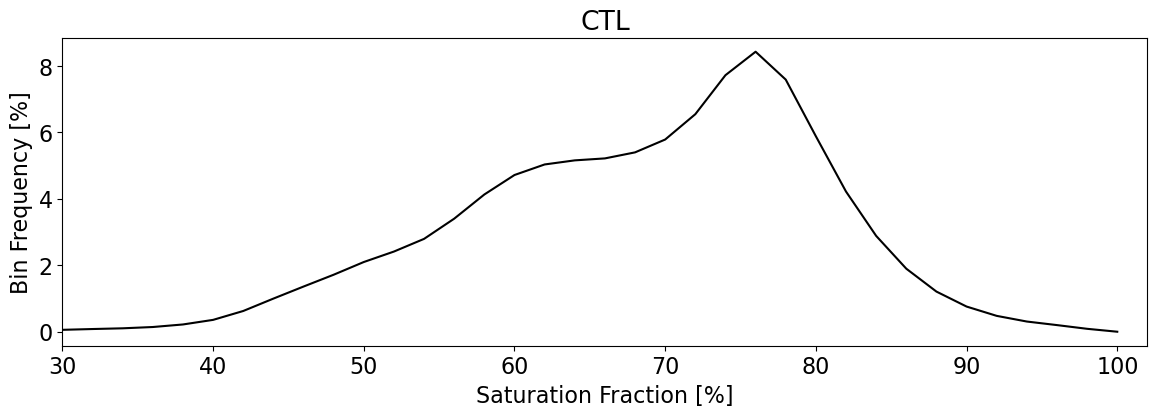

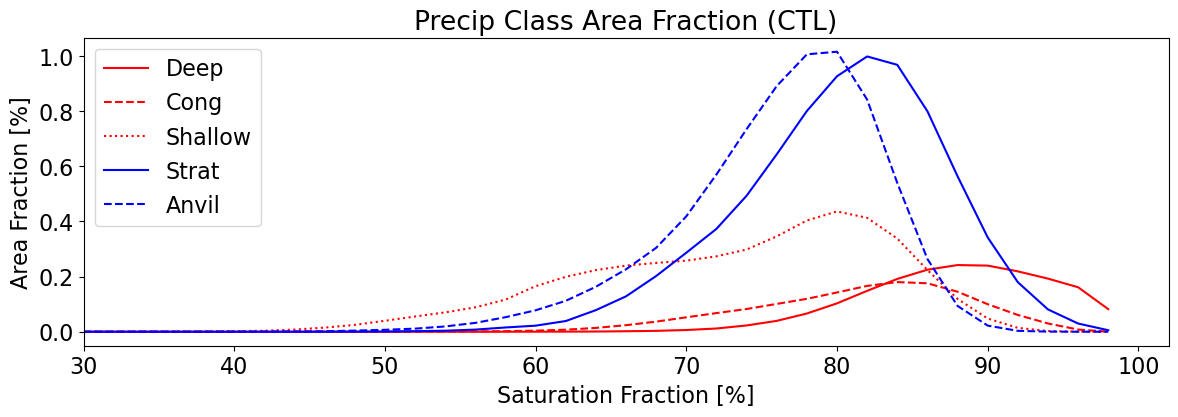

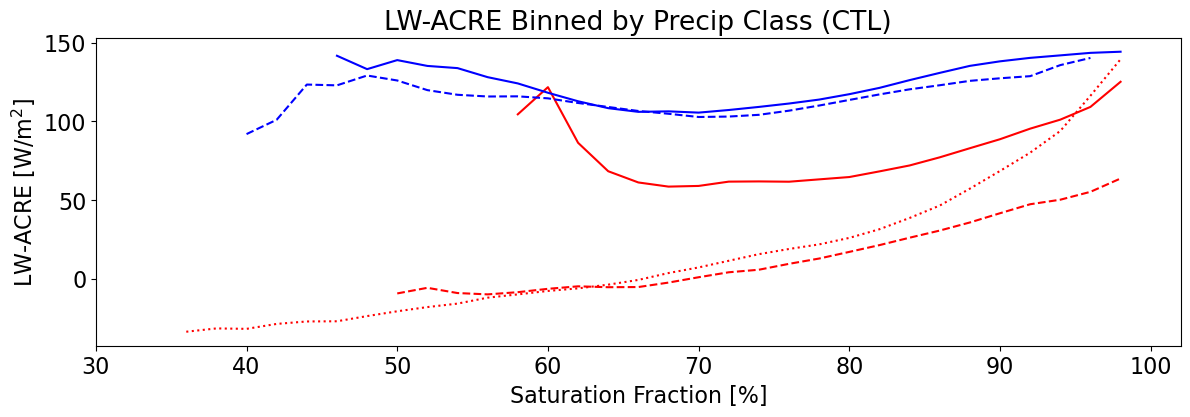

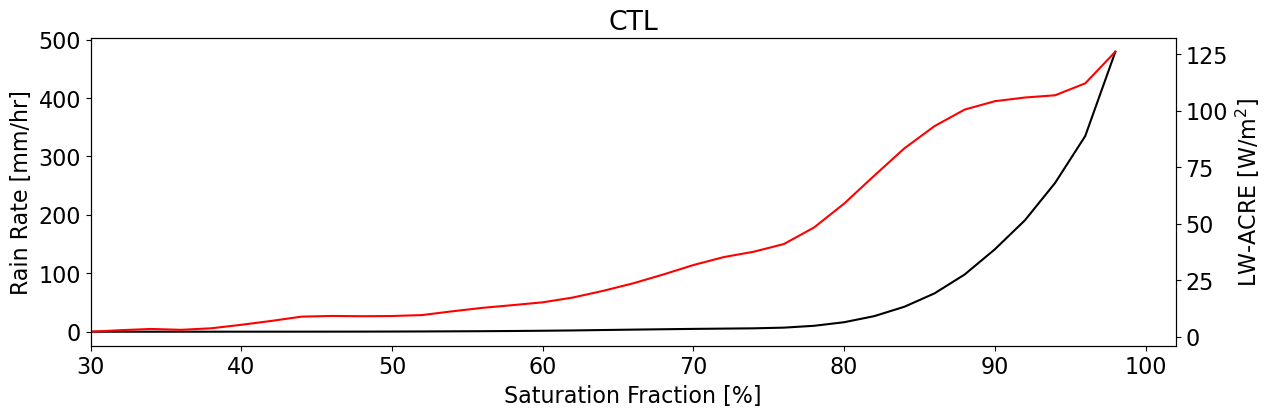



Running for  pw



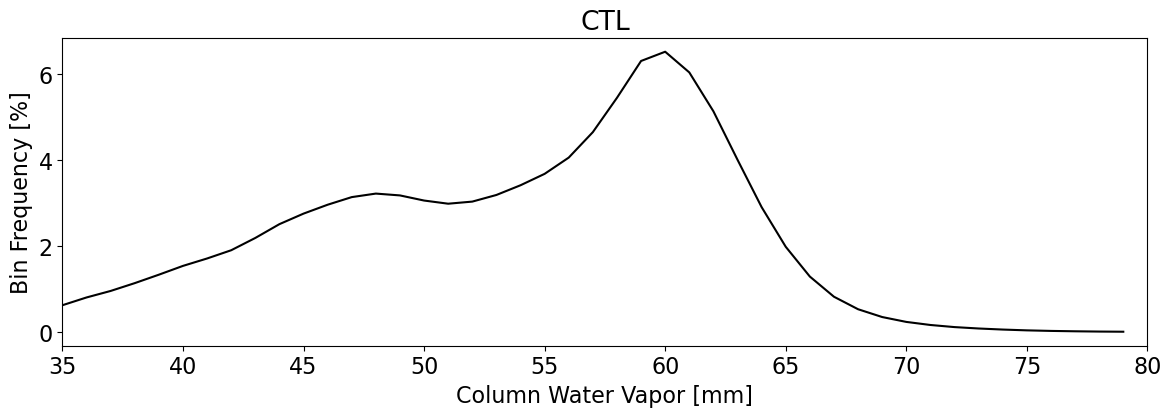

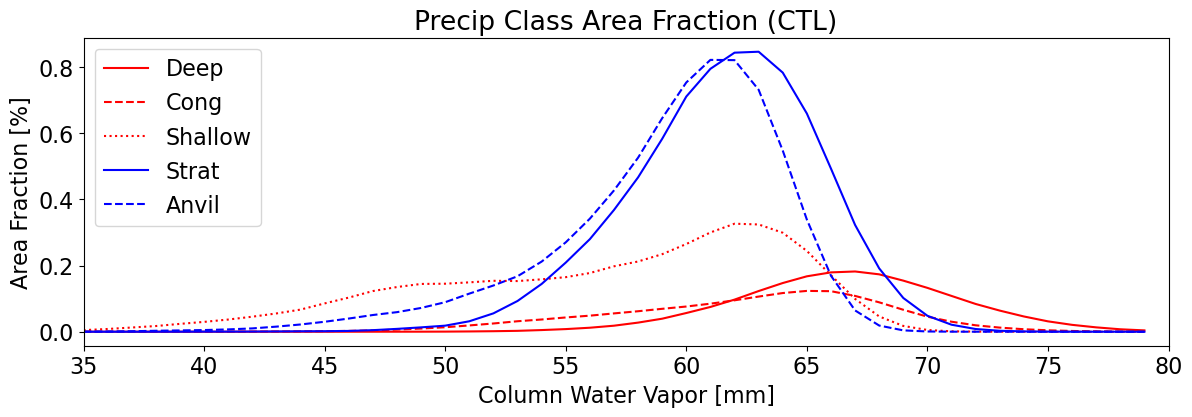

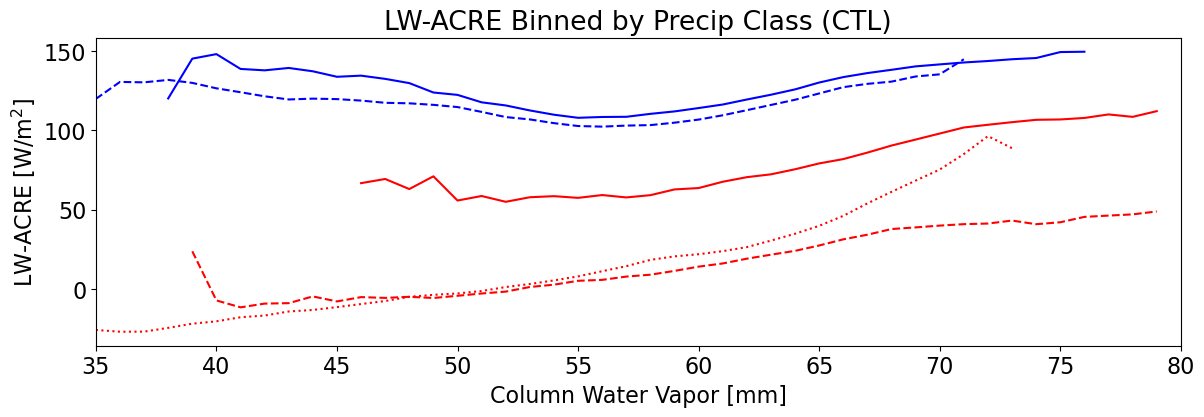

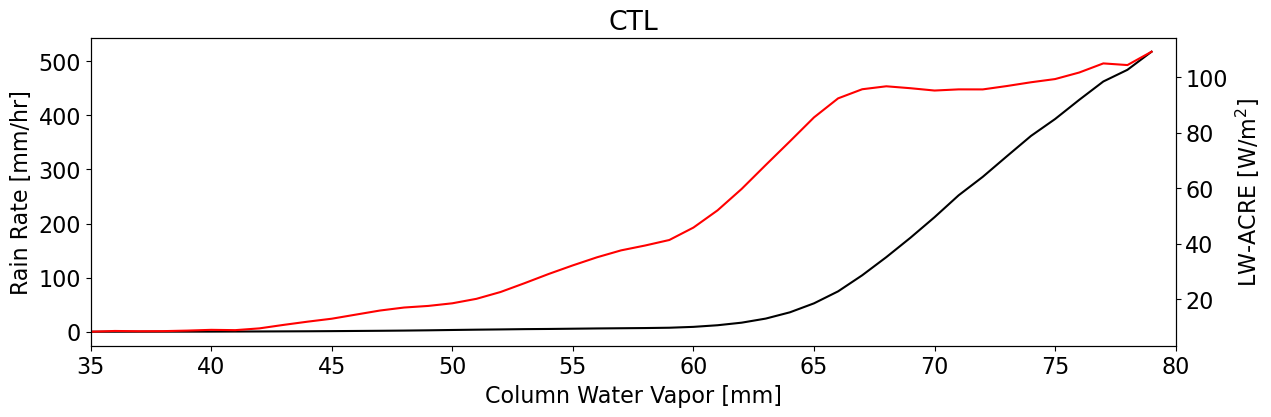



Running for  rain



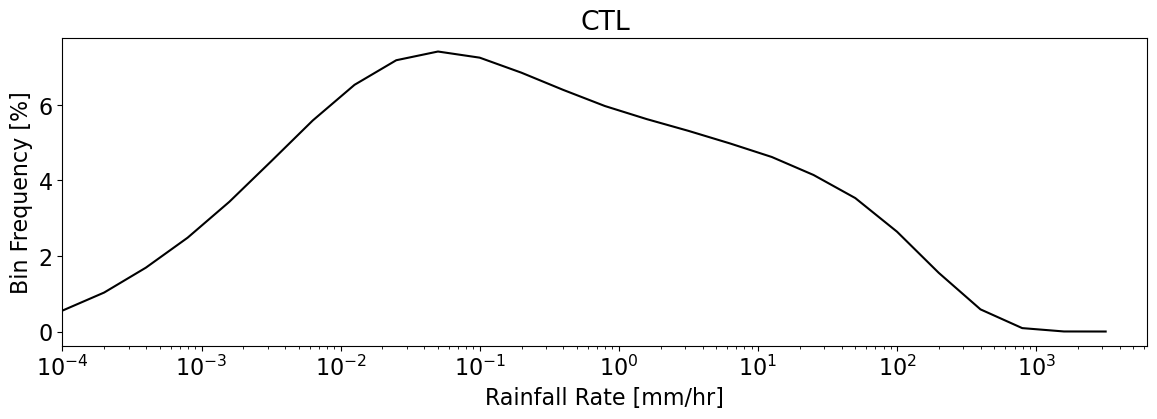

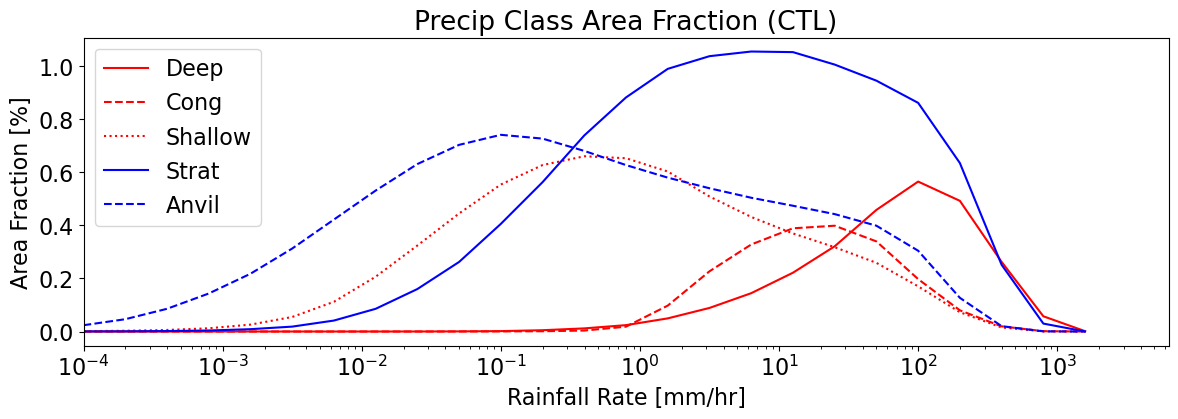

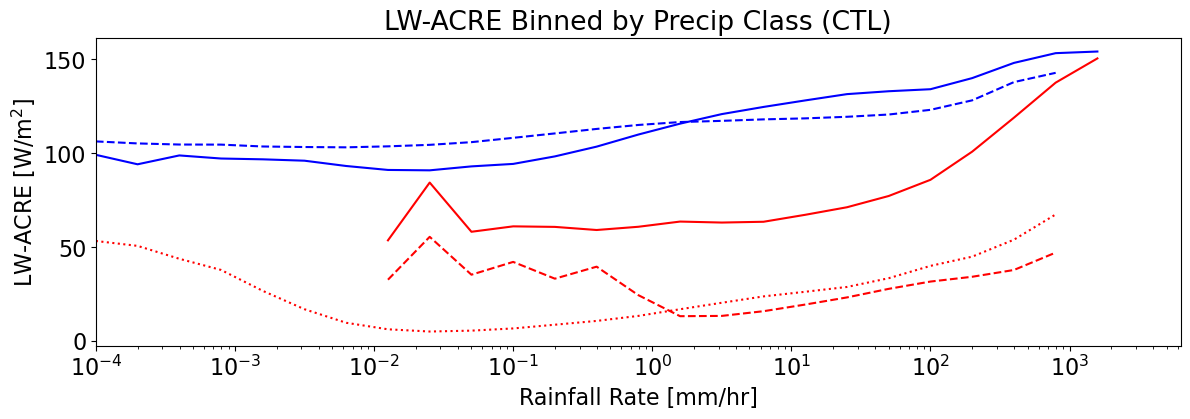

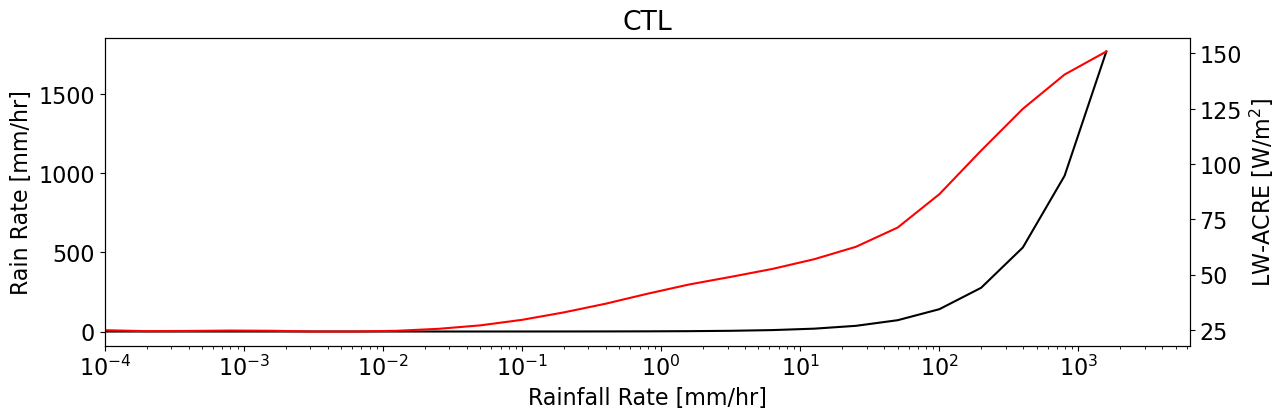

In [38]:
# Select variable (2D; independent var)
# ivar_select = 'strat_area' # Don't think this will work

ivars=['sf', 'pw', 'rain']

for ivar_select in ivars:

    print("Running for ",ivar_select)
    print()

    ivar_all, bins, bin_axis, xlabel, log_x = binvar_settings(ivar_select, pw_all, satfrac_all, rain_all, lwacre_all)
    binned_vars = run_binning(pclass_all, bins, ivar_all, pw_all, satfrac_all, lwacre_all, rain_all)

    nbins = np.size(bins)

    plot_bin_freq(bins, binned_vars['bin_freq'], tests, xlabel, log_x)
    plot_pclass_area(bins, binned_vars['pclass_area'], tests, xlabel, log_x)
    plot_cbinned_acre(bins, binned_vars['lwacre_class'], tests, xlabel, log_x)
    plot_rain_acre(bins, binned_vars['rain_binned'], binned_vars['lwacre_binned'], tests, xlabel, log_x)

    print()
    print()

### LW ACRE by classification

### Weighted LW ACRE by classification

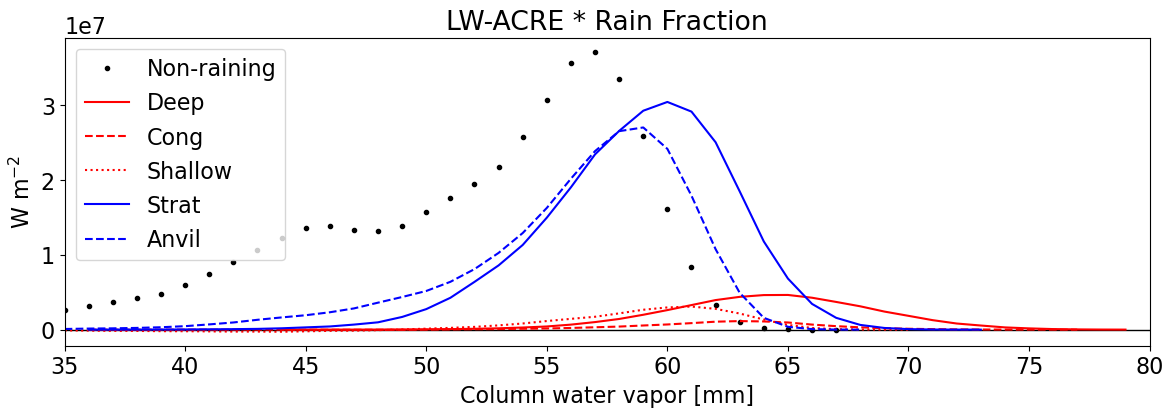

In [123]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'

ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        
        plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)
        
        # As fraction of all-rain-total
        total=np.sum(strat_binned[ktest,:,:])
        fraction = strat_binned[ktest,:,:]#/total

        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,0]*fraction[:,0] \
                 , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,1]*fraction[:,1] \
                 , "-r", label="Deep")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,2]*fraction[:,2] \
                 , "--r", label="Cong")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,3]*fraction[:,3] \
                 , ":r", label="Shallow")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,4]*fraction[:,4] \
                 , "-b", label="Strat")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,5]*fraction[:,5] \
                 , "--b", label="Anvil")

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        plt.legend(loc="upper left")

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()